In [1]:
import pandas as pd
from datetime import datetime
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import glob

In [2]:
csvs = glob.glob('data/accepted/*.csv')
# make sure all csv files have the same headers
with open(csvs[0], 'r') as f:
    columns = f.readlines()[0]
for c in csvs[1:]:
    with open(c, 'r') as f:
        if f.readlines()[0] != columns:
            print(c)

In [3]:
dtype = {'id':str,'member_id':str,'loan_amnt':float,'funded_amnt':float,'funded_amnt_inv':float,
         'term':str,'int_rate':str,
         'installment':float,'grade':str,'sub_grade':str,'emp_title':str,'emp_length':str,'home_ownership':str,
         'annual_inc':float,'verification_status':str,'issue_d':str,'loan_status':str,'pymnt_plan':str,'url':str,
         'desc':str,'purpose':str,'title':str,'zip_code':str,'addr_state':str,'dti':float,'delinq_2yrs':float,
         'earliest_cr_line':str,'inq_last_6mths':float,'mths_since_last_delinq':float,
         'mths_since_last_record':float,
         'open_acc':float,'pub_rec':float,'revol_bal':float,'total_acc':float,'initial_list_status':str,
         'out_prncp':float,
         'out_prncp_inv':float,'total_pymnt':float,'total_pymnt_inv':float,'total_rec_prncp':float,
         'total_rec_int':float,
         'total_rec_late_fee':float,'recoveries':float,'collection_recovery_fee':float,'last_pymnt_d':str,
         'last_pymnt_amnt':float,'next_pymnt_d':str,'last_credit_pull_d':str,'collections_12_mths_ex_med':float,
         'mths_since_last_major_derog':float,'policy_code':str,'application_type':str,'annual_inc_joint':float,
         'dti_joint':float,'verification_status_joint':str,'acc_now_delinq':float,'tot_coll_amt':float,
         'tot_cur_bal':float,
         'open_acc_6m':float,'open_act_il':float,'open_il_12m':float,'open_il_24m':float,
         'mths_since_rcnt_il':float,'total_bal_il':float,
         'il_util':str,'open_rv_12m':float,'open_rv_24m':float,'max_bal_bc':float,'all_util':float,
         'total_rev_hi_lim':float,
         'inq_fi':float,'total_cu_tl':float,'inq_last_12m':float,'acc_open_past_24mths':float,'avg_cur_bal':float,
         'bc_open_to_buy':str,'bc_util':str,'chargeoff_within_12_mths':float,'delinq_amnt':float,
         'mo_sin_old_il_acct':str,
         'mo_sin_old_rev_tl_op':str,'mo_sin_rcnt_rev_tl_op':str,'mo_sin_rcnt_tl':str,'mort_acc':float,
         'mths_since_recent_bc':float,'mths_since_recent_bc_dlq':float,'mths_since_recent_inq':float,
         'mths_since_recent_revol_delinq':float,
         'num_accts_ever_120_pd':float,'num_actv_bc_tl':float,'num_actv_rev_tl':float,'num_bc_sats':float,
         'num_bc_tl':float,
         'num_il_tl':float,'num_op_rev_tl':float,'num_rev_accts':float,'num_rev_tl_bal_gt_0':float,'num_sats':float,
         'num_tl_120dpd_2m':float,'num_tl_30dpd':float,'num_tl_90g_dpd_24m':float,'num_tl_op_past_12m':float,
         'pct_tl_nvr_dlq':float,'percent_bc_gt_75':float,'pub_rec_bankruptcies':float,'tax_liens':float,
         'tot_hi_cred_lim':float,
         'total_bal_ex_mort':float,'total_bc_limit':float,'total_il_high_credit_limit':float,'revol_bal_joint':float,
         'sec_app_earliest_cr_line':str,'sec_app_inq_last_6mths':float,'sec_app_mort_acc':str,'sec_app_open_acc':str,
         'sec_app_revol_util':str,'sec_app_open_act_il':str,'sec_app_num_rev_accts':float,
         'sec_app_chargeoff_within_12_mths':float,
         'sec_app_collections_12_mths_ex_med':float,'sec_app_mths_since_last_major_derog':float,'hardship_flag':str,
         'hardship_type':str,'hardship_reason':str,'hardship_status':str,'deferral_term':str,'hardship_amount':float,
         'hardship_start_date':str,'hardship_end_date':str,'payment_plan_start_date':str,'hardship_length':str,
         'hardship_dpd':float,'hardship_loan_status':str,'orig_projected_additional_accrued_interest':float,
         'hardship_payoff_balance_amount':float,'hardship_last_payment_amount':float,'disbursement_method':str,
         'debt_settlement_flag':str,'debt_settlement_flag_date':str,'settlement_status':str,'settlement_date':str,
         'settlement_amount':float,'settlement_percentage':float,'settlement_term':str}

In [4]:
df = pd.DataFrame(columns=dtype.keys())
for c in csvs:
    df = df.append(pd.read_csv(c, dtype=dtype))
print("number of data points: {}".format(len(df)))

number of data points: 1646801


## Drop current and unlabeled borrowers

In [5]:
print(df.loan_status.value_counts(normalize=True))

Current                                                0.492101
Fully Paid                                             0.380819
Charged Off                                            0.097637
Late (31-120 days)                                     0.015266
In Grace Period                                        0.009458
Late (16-30 days)                                      0.003006
Does not meet the credit policy. Status:Fully Paid     0.001207
Does not meet the credit policy. Status:Charged Off    0.000462
Default                                                0.000044
Name: loan_status, dtype: float64


We drop current borrowers, as we are primarily interested in those who have already paid off or charged off on their loans. We save the current borrowers to predict how they will behave for future projects. Note that "Charged Off" means no further payment is expected. This typically occurs when a payment is 150+ days past due. "Default" typically means the borrower has not made a payment for 121+ days, but the account has not been closed or sent to collections yet (see https://help.lendingclub.com/hc/en-us/articles/216127747-What-is-the-difference-between-a-loan-that-is-in-default-and-a-loan-that-has-been-charged-off-).

In [6]:
# save current borrowers for separate analysis
current_df = df[(df.loan_status != 'Fully Paid') & (df.loan_status != 'Charged Off') 
                & (df.loan_status != 'Does not meet the credit policy. Status:Fully Paid')
                & (df.loan_status != 'Does not meet the credit policy. Status:Charged Off')]

In [7]:
current_df.to_csv("data/current_borrowers.csv", index=False)

We drop the unlabeled data points, as the proportion of unlabeled points (about .003%) is marginal.

In [8]:
print("number of unlabeled points: {}".format(len(df) - df.loan_status.value_counts().sum()))

number of unlabeled points: 23


In [9]:
# drop unlabeled data points (nan)
df = df.dropna(subset=['loan_status'])
len(df)

1646778

The labels that include "Does not meet the credit policy" means those applicants would not be awarded a loan under Lending Club's current policy. We omit them from this analysis, as we are concerned with the current policy of Lending Club.

In [10]:
unqualified_df = df[df.loan_status.str.contains("Does not meet the credit policy")]
len(unqualified_df)

2749

In [11]:
# save those who don't meet the policy today in a separate csv
unqualified_df.to_csv("data/unqualified_df.csv", index=False)
df = df[(df.loan_status != 'Does not meet the credit policy. Status:Fully Paid') & 
        (df.loan_status != 'Does not meet the credit policy. Status:Charged Off')]
len(df)

1644029

In [12]:
# drop current borrowers
df = df[(df.loan_status!="Current") & (df.loan_status!="In Grace Period") &
       (df.loan_status!="Late (31-120 days)") & (df.loan_status!="Late (16-30 days)") &
       (df.loan_status!="Default")].copy()

In [13]:
print(df.loan_status.unique())

['Fully Paid' 'Charged Off']


In [14]:
df.loan_status.value_counts(normalize=True)

Fully Paid     0.795934
Charged Off    0.204066
Name: loan_status, dtype: float64

Observations labeled with "Does not meet the credit policy" are people that borrowed from Lending Club in the past, but would not currently qualify for a loan under Lending Club's current policy. We save them as a separate dataframe for further analysis; perhaps we can identify the change in Lending Club's policy that would cause those borrowers to not qualify for a loan today.

### Label the data

In [15]:
df.loan_status = df.loan_status.map({'Fully Paid':0, 'Charged Off':1})
df.to_csv('data/labeled.csv', index=False)

In [16]:
# change loan_status to int, due to encoded labels
dtype['loan_status'] = int
df = pd.read_csv('data/labeled.csv', dtype=dtype)
len(df.columns)

145

### Remove features that are not available for new applicants

Since we want to this analysis to be useful for new applicants, we drop the columns that are available for only those whose applications have been accepted and have already received the loan for which they applied. Many of these features have to do with payment schedules, recovery fees, and hardship plans.

In [17]:
feats = ['collection_recovery_fee', 'funded_amnt', 'funded_amnt_inv', 'issue_d', 'last_credit_pull_d',
         'last_pymnt_amnt', 'last_pymnt_d', 'next_pymnt_d', 'out_prncp', 'out_prncp_inv', 'pymnt_plan',
         'recoveries', 'term', 'total_pymnt', 'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee',
         'total_rec_prncp', 'hardship_flag', 'hardship_type', 'hardship_reason', 'hardship_status',
         'deferral_term', 'hardship_amount', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date',
         'hardship_length', 'hardship_dpd', 'hardship_loan_status', 'orig_projected_additional_accrued_interest',
         'hardship_payoff_balance_amount', 'hardship_last_payment_amount', 'disbursement_method', 
         'debt_settlement_flag', 'debt_settlement_flag_date', 'settlement_status', 'settlement_date',
         'settlement_amount', 'settlement_percentage', 'settlement_term']
df.drop(feats, axis=1, inplace=True)

### Remove uniform columns

In [18]:
# find features with uniform values
for col in df.columns:
    if len(df[col].unique()) == 1:
        print(col, len(df[col].unique()))
        df.drop(col, axis=1, inplace=True)

id 1
member_id 1
policy_code 1
url 1


In [19]:
df.shape

(787910, 100)

### Remove nearly uniform columns (99% or more one value)

In [20]:
df.application_type.value_counts(normalize=True)

Individual    0.9958
Joint App     0.0042
Name: application_type, dtype: float64

In [21]:
df.drop('application_type', axis=1, inplace=True)

In [22]:
df.num_tl_120dpd_2m.value_counts(normalize=True)

0.0    0.999182
1.0    0.000783
2.0    0.000029
3.0    0.000004
6.0    0.000001
Name: num_tl_120dpd_2m, dtype: float64

In [23]:
df.drop('num_tl_120dpd_2m', axis=1, inplace=True)

In [24]:
df.num_tl_30dpd.value_counts(normalize=True)

0.0    0.996807
1.0    0.003034
2.0    0.000130
3.0    0.000021
4.0    0.000007
Name: num_tl_30dpd, dtype: float64

In [25]:
df.drop('num_tl_30dpd', axis=1, inplace=True)

In [26]:
df.num_tl_90g_dpd_24m.value_counts(normalize=True).iloc[:10]

0.0    0.942944
1.0    0.042647
2.0    0.008751
3.0    0.002327
4.0    0.001284
5.0    0.000643
6.0    0.000455
7.0    0.000280
8.0    0.000186
9.0    0.000135
Name: num_tl_90g_dpd_24m, dtype: float64

In [27]:
df.drop('num_tl_90g_dpd_24m', axis=1, inplace=True)

In [28]:
df.chargeoff_within_12_mths.value_counts(normalize=True).iloc[:10]

0.0     0.992377
1.0     0.006892
2.0     0.000597
3.0     0.000090
4.0     0.000025
5.0     0.000009
7.0     0.000004
6.0     0.000004
8.0     0.000001
10.0    0.000001
Name: chargeoff_within_12_mths, dtype: float64

In [29]:
df.drop('chargeoff_within_12_mths', axis=1, inplace=True)

In [30]:
df.collections_12_mths_ex_med.value_counts(normalize=True).iloc[:10]

0.0     0.986973
1.0     0.012115
2.0     0.000781
3.0     0.000083
4.0     0.000027
6.0     0.000008
5.0     0.000006
12.0    0.000003
7.0     0.000001
16.0    0.000001
Name: collections_12_mths_ex_med, dtype: float64

In [31]:
df.drop('collections_12_mths_ex_med', axis=1, inplace=True)

In [32]:
df.tax_liens.value_counts(normalize=True).iloc[:10]

0.0    0.971679
1.0    0.019605
2.0    0.005177
3.0    0.001787
4.0    0.000803
5.0    0.000416
6.0    0.000228
7.0    0.000112
8.0    0.000055
9.0    0.000042
Name: tax_liens, dtype: float64

In [33]:
df.drop('tax_liens', axis=1, inplace=True)

In [34]:
df.acc_now_delinq.value_counts(normalize=True)

0.0    0.995480
1.0    0.004264
2.0    0.000216
3.0    0.000027
4.0    0.000009
5.0    0.000003
6.0    0.000001
Name: acc_now_delinq, dtype: float64

In [35]:
df.drop('acc_now_delinq', axis=1, inplace=True)

### Remove columns with a majority (70% or more) of missing values¶

In [36]:
null_counts = dict(df.isnull().sum())
null_cols = []
for key,val in null_counts.items():
    if val/df.shape[0] >= .7:
        print("{:<35}\t{}".format((key), val/df.shape[0]))
    if val/df.shape[0] >= 0.7:
        null_cols.append(key)

all_util                           	0.7942696500869388
annual_inc_joint                   	0.9958002817580688
desc                               	0.8483748143823533
dti_joint                          	0.9958002817580688
il_util                            	0.8200835120762524
inq_fi                             	0.7942569582820372
inq_last_12m                       	0.7942582274625275
max_bal_bc                         	0.7942569582820372
mths_since_last_major_derog        	0.749250548920562
mths_since_last_record             	0.8365016308969299
mths_since_rcnt_il                 	0.7988006244368011
mths_since_recent_bc_dlq           	0.7682438349557691
open_acc_6m                        	0.7942582274625275
open_act_il                        	0.7942569582820372
open_il_12m                        	0.7942569582820372
open_il_24m                        	0.7942569582820372
open_rv_12m                        	0.7942569582820372
open_rv_24m                        	0.7942569582820372
revol_bal_j

In [37]:
print(len(null_cols))
df.drop(null_cols, axis=1, inplace=True)
print(len(df.columns))

32
60


In [38]:
df['zip_code'].head()

0    860xx
1    309xx
2    606xx
3    917xx
4    972xx
Name: zip_code, dtype: object

In [39]:
# drop the zip_code feature, since we can't work with 3-digit zip codes, and addr_state gives the state
df.drop("zip_code", axis=1, inplace=True)

In [40]:
df.drop('addr_state', axis=1, inplace=True)

In [41]:
df['title'].head(10)

0                                 Computer
1                                     bike
2                     real estate business
3                                 personel
4                                 Personal
5    My wedding loan I promise to pay back
6                                     Loan
7                          Car Downpayment
8     Expand Business & Buy Debt Portfolio
9              Building my credit history.
Name: title, dtype: object

In [42]:
# make lower case
df['title'] = df['title'].str.lower()
# got rid of about 10000 categories
print(len(df['title'].unique()))
print(df['title'].isnull().sum())

50798
7387


In [44]:
# keep top x categories
# use substring matching to combine categories (other ways to combine categories)
# make new categories for leftovers
print(len(df['title'].unique()))
df['title'].value_counts(normalize=True).iloc[:15]

50798


debt consolidation           0.482619
credit card refinancing      0.163980
home improvement             0.051159
other                        0.040810
major purchase               0.015467
consolidation                0.009376
medical expenses             0.008539
business                     0.008346
car financing                0.006965
debt consolidation loan      0.005800
vacation                     0.005336
moving and relocation        0.005216
credit card consolidation    0.004302
personal loan                0.004033
home buying                  0.003472
Name: title, dtype: float64

In [45]:
df['purpose'].value_counts(normalize=True)

debt_consolidation    0.590989
credit_card           0.214731
home_improvement      0.062277
other                 0.053793
major_purchase        0.021473
small_business        0.012644
car                   0.011010
medical               0.010686
moving                0.007026
vacation              0.006258
house                 0.005073
wedding               0.002882
renewable_energy      0.000742
educational           0.000414
Name: purpose, dtype: float64

In [46]:
# drop title (for now), as purpose is a more uniform, consistent way to measure a similar thing (high correlation)
df.drop('title', axis=1, inplace=True)

In [47]:
df.emp_title.head()

0                         NaN
1                       Ryder
2                         NaN
3         AIR RESOURCES BOARD
4    University Medical Group
Name: emp_title, dtype: object

In [48]:
len(df.emp_title.unique())

274750

In [49]:
# for similar reasoning, drop emp_title (user input, very messy)
df.drop('emp_title', axis=1, inplace=True)

In [50]:
df.grade.value_counts(normalize=True)

B    0.288898
C    0.276461
A    0.163724
D    0.156942
E    0.078119
F    0.028459
G    0.007397
Name: grade, dtype: float64

In [51]:
df.sub_grade.value_counts(normalize=True)

B3    0.063248
B4    0.062964
C1    0.061550
C2    0.058541
B5    0.058304
B2    0.054901
C3    0.054893
C4    0.053462
B1    0.049482
C5    0.048014
A5    0.046668
D1    0.040115
A4    0.038758
D2    0.034611
D3    0.030080
D4    0.028469
A1    0.026913
A3    0.026428
A2    0.024957
D5    0.023668
E1    0.020054
E2    0.018187
E3    0.015292
E4    0.013153
E5    0.011433
F1    0.008732
F2    0.006508
F3    0.005507
F4    0.004310
F5    0.003401
G1    0.002453
G2    0.001845
G3    0.001325
G4    0.000979
G5    0.000795
Name: sub_grade, dtype: float64

In [52]:
df.grade = df.sub_grade.apply(lambda x: x[0] if x[0]=='E' or x[0]=='F' or x[0]=='G' else x)

In [53]:
df.grade.value_counts(normalize=True)

E     0.078119
B3    0.063248
B4    0.062964
C1    0.061550
C2    0.058541
B5    0.058304
B2    0.054901
C3    0.054893
C4    0.053462
B1    0.049482
C5    0.048014
A5    0.046668
D1    0.040115
A4    0.038758
D2    0.034611
D3    0.030080
D4    0.028469
F     0.028459
A1    0.026913
A3    0.026428
A2    0.024957
D5    0.023668
G     0.007397
Name: grade, dtype: float64

In [54]:
# drop sub_grade, as that information can be captured in our engineered grade
df.drop('sub_grade', axis=1, inplace=True)

### Change features to floats/ints

In [55]:
df['revol_util'].head()

0    83.7%
1     9.4%
2    98.5%
3      21%
4    53.9%
Name: revol_util, dtype: object

In [56]:
# change revol_util to floats
df.revol_util = df.revol_util.str[:-1].astype('float')/100
df.revol_util.head()

0    0.837
1    0.094
2    0.985
3    0.210
4    0.539
Name: revol_util, dtype: float64

In [57]:
# change earliest_cr_line to year so we can easily use it
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line']).dt.year

We keep interest rate, as it is calculated based off the grade which Lending Club gives an applicant. The method of grade assignment is explained in this link: https://www.lendingclub.com/foliofn/rateDetail.action.

In [58]:
df['int_rate'].head()

0     10.65%
1     15.27%
2     15.96%
3     13.49%
4     12.69%
Name: int_rate, dtype: object

In [59]:
df.int_rate = df.int_rate.str[:-1].astype('float')/100
df.int_rate.head()

0    0.1065
1    0.1527
2    0.1596
3    0.1349
4    0.1269
Name: int_rate, dtype: float64

In [60]:
df.bc_util = df.bc_util.astype('float')

In [61]:
df.bc_util.tail(10)

787900    12.8
787901    51.7
787902    83.5
787903    20.0
787904    54.2
787905    60.5
787906    68.0
787907    61.7
787908    95.8
787909    48.0
Name: bc_util, dtype: float64

In [62]:
df.bc_open_to_buy = df.bc_open_to_buy.astype('float')

In [63]:
df.dtypes.unique()

array([dtype('float64'), dtype('int64'), dtype('O')], dtype=object)

In [64]:
df.select_dtypes(include=['O']).columns

Index(['emp_length', 'grade', 'home_ownership', 'initial_list_status',
       'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op',
       'mo_sin_rcnt_tl', 'purpose', 'verification_status'],
      dtype='object')

In [65]:
df['emp_length'].head()

0    10+ years
1     < 1 year
2    10+ years
3    10+ years
4       1 year
Name: emp_length, dtype: object

In [66]:
df['emp_length'] = df['emp_length'].apply(lambda x: -1 if x=='n/a' else 0 if x[0]=='<' else int(x[0]))

In [67]:
df['grade'].astype('category').cat.codes.value_counts(normalize=True)

20    0.078119
7     0.063248
8     0.062964
10    0.061550
11    0.058541
9     0.058304
6     0.054901
12    0.054893
13    0.053462
5     0.049482
14    0.048014
4     0.046668
15    0.040115
3     0.038758
16    0.034611
17    0.030080
18    0.028469
21    0.028459
0     0.026913
2     0.026428
1     0.024957
19    0.023668
22    0.007397
dtype: float64

In [68]:
df['grade'] = df['grade'].astype('category').cat.codes

In [69]:
df['home_ownership'].value_counts(normalize=True)

MORTGAGE    0.499525
RENT        0.399010
OWN         0.101116
OTHER       0.000183
ANY         0.000112
NONE        0.000055
Name: home_ownership, dtype: float64

In [70]:
ownership_dict = {'MORTGAGE':0, 'RENT': 1, 'OWN': 2, 'OTHER': 3, 'ANY': 4, 'NONE': 5}
df.home_ownership = df.home_ownership.map(ownership_dict)

In [71]:
df['initial_list_status'].value_counts(normalize=True)

f    0.513104
w    0.486896
Name: initial_list_status, dtype: float64

In [72]:
df['initial_list_status'] = df['initial_list_status'].astype('category').cat.codes

In [73]:
df['mo_sin_old_il_acct'] = df['mo_sin_old_il_acct'].astype(float)
df['mo_sin_old_rev_tol_op'] = df['mo_sin_old_rev_tl_op'].astype(float)
df['mo_sin_rcnt_rev_tl_op'] = df['mo_sin_rcnt_rev_tl_op'].astype(float)
df['mo_sin_rcnt_tl'] = df['mo_sin_rcnt_tl'].astype(float)
df['mo_sin_old_rev_tl_op'] = df['mo_sin_old_rev_tl_op'].astype(float)

In [74]:
df['purpose'].value_counts(normalize=True)

debt_consolidation    0.590989
credit_card           0.214731
home_improvement      0.062277
other                 0.053793
major_purchase        0.021473
small_business        0.012644
car                   0.011010
medical               0.010686
moving                0.007026
vacation              0.006258
house                 0.005073
wedding               0.002882
renewable_energy      0.000742
educational           0.000414
Name: purpose, dtype: float64

In [75]:
df['purpose'].astype('category').cat.codes.value_counts(normalize=True)

2     0.590989
1     0.214731
4     0.062277
9     0.053793
6     0.021473
11    0.012644
0     0.011010
7     0.010686
8     0.007026
12    0.006258
5     0.005073
13    0.002882
10    0.000742
3     0.000414
dtype: float64

In [76]:
df['purpose'] = df['purpose'].astype('category').cat.codes

In [77]:
df['verification_status'].value_counts(normalize=True)

Source Verified    0.359235
Verified           0.332176
Not Verified       0.308589
Name: verification_status, dtype: float64

In [78]:
df['verification_status'] = df['verification_status'].astype('category').cat.codes

In [79]:
df.dtypes.unique()

array([dtype('float64'), dtype('int64'), dtype('int8')], dtype=object)

In [80]:
print(df.columns[df.isnull().any()], len(df.columns[df.isnull().any()]))

Index(['acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'dti', 'inq_last_6mths', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
       'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
       'mths_since_last_delinq', 'mths_since_recent_bc',
       'mths_since_recent_inq', 'mths_since_recent_revol_delinq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats',
       'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75',
       'pub_rec_bankruptcies', 'revol_util', 'tot_coll_amt', 'tot_cur_bal',
       'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit', 'total_rev_hi_lim',
       'mo_sin_old_rev_tol_op'],
      dtype='object') 38


In [81]:
# save the work we've done thus far
df.to_csv("data/cleaned_features.csv", index=False)

### Create train/test split and fill missing values

In [82]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('loan_status', axis=1), 
                                                    df['loan_status'], test_size=.25)

In [83]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((590932, 55), (590932,), (196978, 55), (196978,))

In [84]:
print(y_train.value_counts(normalize=True), '\n', y_test.value_counts(normalize=True))

0    0.79596
1    0.20404
Name: loan_status, dtype: float64 
 0    0.795855
1    0.204145
Name: loan_status, dtype: float64


In [85]:
def describe_missing(var):
    print(X_train[var].isnull().sum()/X_train.shape[0])
    print(X_train[var].describe())
    print(y_train[X_train[var].isnull()].value_counts(normalize=True))
    X_train[var].hist(bins=15, normed=True)
    plt.show()

In [86]:
# find column with most missing values
X_train.count().idxmin()

'mths_since_recent_revol_delinq'

0.6751504403213906
count    191964.000000
mean         36.186931
std          22.436783
min           0.000000
25%          17.000000
50%          33.000000
75%          53.000000
max         180.000000
Name: mths_since_recent_revol_delinq, dtype: float64
0    0.799946
1    0.200054
Name: loan_status, dtype: float64


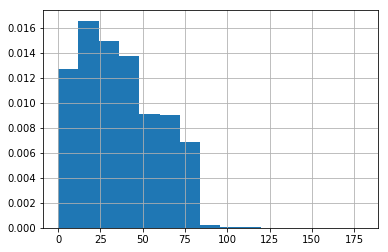

In [87]:
describe_missing('mths_since_recent_revol_delinq')

We fill missing values in `mth_since_recent_revol_delinq` with the rounded mean, as all the values are integers.

In [88]:
X_test['mths_since_recent_revol_delinq'].fillna(np.round(X_train['mths_since_recent_revol_delinq'].mean()), inplace=True)
X_train['mths_since_recent_revol_delinq'].fillna(np.round(X_train['mths_since_recent_revol_delinq'].mean()), inplace=True)

In [89]:
# find column with most missing values
X_train.count().idxmin()

'mths_since_last_delinq'

0.5131910270555664
count    287671.000000
mean         34.496689
std          21.937288
min           0.000000
25%          16.000000
50%          31.000000
75%          50.000000
max         188.000000
Name: mths_since_last_delinq, dtype: float64
0    0.802223
1    0.197777
Name: loan_status, dtype: float64


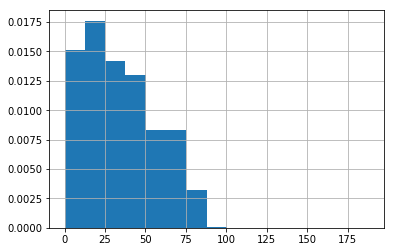

In [90]:
describe_missing('mths_since_last_delinq')

Similarly, we fill missing values in mth_since_last_delinq with the rounded mean, as all the values are integers.



In [91]:
X_test['mths_since_last_delinq'].fillna(np.round(X_train['mths_since_last_delinq'].mean()), inplace=True)
X_train['mths_since_last_delinq'].fillna(np.round(X_train['mths_since_last_delinq'].mean()), inplace=True)

In [92]:
# find column with most missing values
X_train.count().idxmin()

'mths_since_recent_inq'

0.14665816032978413
count    504267.000000
mean          6.599500
std           5.801907
min           0.000000
25%           2.000000
50%           5.000000
75%          10.000000
max          25.000000
Name: mths_since_recent_inq, dtype: float64
0    0.847205
1    0.152795
Name: loan_status, dtype: float64


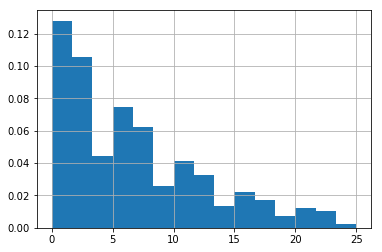

In [93]:
describe_missing('mths_since_recent_inq')

Similarly, we fill missing values in mth_since_recent_inq with the rounded mean, as all the values are integers.



In [95]:
X_test['mths_since_recent_inq'].fillna(np.round(X_train['mths_since_recent_inq'].mean()), inplace=True)
X_train['mths_since_recent_inq'].fillna(np.round(X_train['mths_since_recent_inq'].mean()), inplace=True)

In [97]:
# find column with most missing values
col = X_train.count().idxmin()
col

'mo_sin_old_il_acct'

0.11283193328504802
count    524256.000000
mean        125.864938
std          51.542486
min           0.000000
25%          98.000000
50%         129.000000
75%         152.000000
max         724.000000
Name: mo_sin_old_il_acct, dtype: float64
0    0.830194
1    0.169806
Name: loan_status, dtype: float64


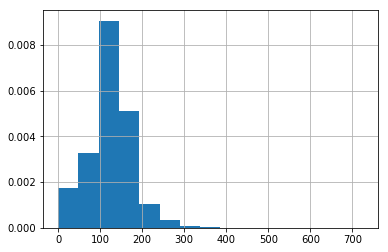

In [98]:
describe_missing(col)

Similarly, we fill missing values in `mo_sin_old_il_acct` with the rounded mean, as all the values are integers.



In [99]:
X_test[col].fillna(np.round(X_train[col].mean()), inplace=True)
X_train[col].fillna(np.round(X_train[col].mean()), inplace=True)

In [100]:
# find column with most missing values
col = X_train.count().idxmin()
col

'pct_tl_nvr_dlq'

0.08606235573636221
count    540075.000000
mean         94.402047
std           8.388411
min           0.000000
25%          91.700000
50%          98.100000
75%         100.000000
max         100.000000
Name: pct_tl_nvr_dlq, dtype: float64
0    0.846157
1    0.153843
Name: loan_status, dtype: float64


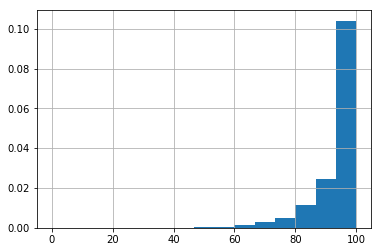

In [101]:
describe_missing(col)

Similarly, we fill missing values in `mo_sin_old_il_acct` with the rounded mean, as all the values are integers.



In [102]:
X_test[col].fillna(np.round(X_train[col].mean()), inplace=True)
X_train[col].fillna(np.round(X_train[col].mean()), inplace=True)

In [103]:
# find column with most missing values
col = X_train.count().idxmin()
col

'avg_cur_bal'

0.0859083617065923
count    540166.000000
mean      13516.440628
std       16211.439444
min           0.000000
25%        3118.000000
50%        7517.000000
75%       18816.000000
max      958084.000000
Name: avg_cur_bal, dtype: float64
0    0.846117
1    0.153883
Name: loan_status, dtype: float64


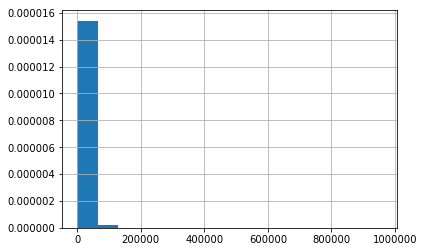

In [104]:
describe_missing(col)

Similarly, we fill missing values in `mo_sin_old_il_acct` with the rounded mean, as all the values are integers.



In [105]:
X_test[col].fillna(np.round(X_train[col].mean()), inplace=True)
X_train[col].fillna(np.round(X_train[col].mean()), inplace=True)

In [106]:
# find column with most missing values
col = X_train.count().idxmin()
col

'mo_sin_old_rev_tl_op'

0.08589482376990923
count    540174.000000
mean        180.699382
std          92.040329
min           2.000000
25%         117.000000
50%         164.000000
75%         228.000000
max         842.000000
Name: mo_sin_old_rev_tl_op, dtype: float64
0    0.846133
1    0.153867
Name: loan_status, dtype: float64


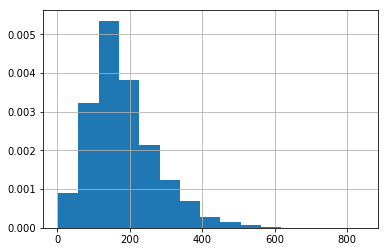

In [107]:
describe_missing(col)

Similarly, we fill missing values in `mo_sin_old_il_acct` with the rounded mean, as all the values are integers.



In [108]:
X_test[col].fillna(np.round(X_train[col].mean()), inplace=True)
X_train[col].fillna(np.round(X_train[col].mean()), inplace=True)

In [109]:
# find column with most missing values
col = X_train.count().idxmin()
col

'mo_sin_rcnt_rev_tl_op'

0.08589482376990923
count    540174.000000
mean         12.698014
std          15.620088
min           0.000000
25%           4.000000
50%           8.000000
75%          15.000000
max         372.000000
Name: mo_sin_rcnt_rev_tl_op, dtype: float64
0    0.846133
1    0.153867
Name: loan_status, dtype: float64


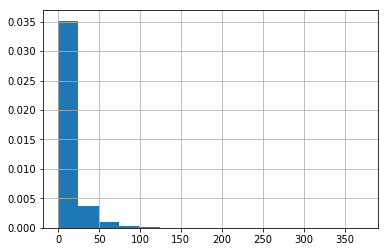

In [110]:
describe_missing(col)

Similarly, we fill missing values in `mo_sin_old_il_acct` with the rounded mean, as all the values are integers.



In [111]:
X_test[col].fillna(np.round(X_train[col].mean()), inplace=True)
X_train[col].fillna(np.round(X_train[col].mean()), inplace=True)

In [112]:
# find column with most missing values
col = X_train.count().idxmin()
col

'num_rev_accts'

0.08589482376990923
count    540174.000000
mean         15.052091
std           8.123566
min           0.000000
25%           9.000000
50%          14.000000
75%          19.000000
max         128.000000
Name: num_rev_accts, dtype: float64
0    0.846152
1    0.153848
Name: loan_status, dtype: float64


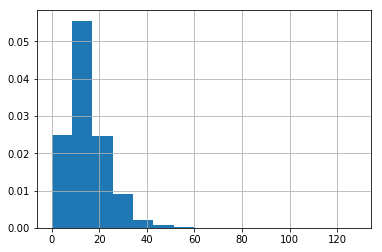

In [113]:
describe_missing(col)

Similarly, we fill missing values in `mo_sin_old_il_acct` with the rounded mean, as all the values are integers.



In [114]:
X_test[col].fillna(np.round(X_train[col].mean()), inplace=True)
X_train[col].fillna(np.round(X_train[col].mean()), inplace=True)

In [115]:
# find column with most missing values
col = X_train.count().idxmin()
col

'mo_sin_old_rev_tol_op'

0.08589482376990923
count    540174.000000
mean        180.699382
std          92.040329
min           2.000000
25%         117.000000
50%         164.000000
75%         228.000000
max         842.000000
Name: mo_sin_old_rev_tol_op, dtype: float64
0    0.846133
1    0.153867
Name: loan_status, dtype: float64


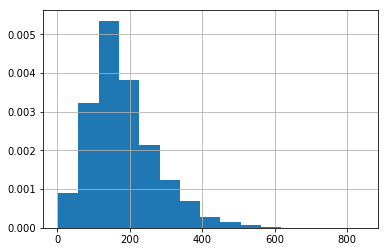

In [116]:
describe_missing(col)

Similarly, we fill missing values in `mo_sin_old_il_acct` with the rounded mean, as all the values are integers.



In [117]:
X_test[col].fillna(np.round(X_train[col].mean()), inplace=True)
X_train[col].fillna(np.round(X_train[col].mean()), inplace=True)

In [118]:
# find column with most missing values
col = X_train.count().idxmin()
col

'mo_sin_rcnt_tl'

0.08589313152782384
count    540175.000000
mean          7.689780
std           8.491822
min           0.000000
25%           3.000000
50%           5.000000
75%          10.000000
max         314.000000
Name: mo_sin_rcnt_tl, dtype: float64
0    0.846149
1    0.153851
Name: loan_status, dtype: float64


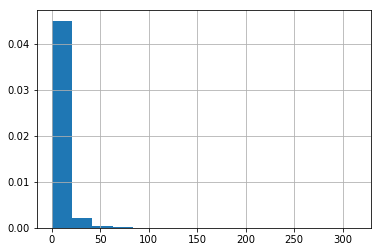

In [119]:
describe_missing(col)

Similarly, we fill missing values in `mo_sin_old_il_acct` with the rounded mean, as all the values are integers.



In [120]:
X_test[col].fillna(np.round(X_train[col].mean()), inplace=True)
X_train[col].fillna(np.round(X_train[col].mean()), inplace=True)

In [121]:
# find column with most missing values
col = X_train.count().idxmin()
col

'num_accts_ever_120_pd'

0.08589313152782384
count    540175.000000
mean          0.493712
std           1.276360
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          51.000000
Name: num_accts_ever_120_pd, dtype: float64
0    0.846149
1    0.153851
Name: loan_status, dtype: float64


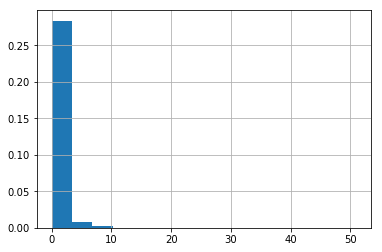

In [122]:
describe_missing(col)

Similarly, we fill missing values in `mo_sin_old_il_acct` with the rounded mean, as all the values are integers.



In [123]:
X_test[col].fillna(np.round(X_train[col].mean()), inplace=True)
X_train[col].fillna(np.round(X_train[col].mean()), inplace=True)

In [124]:
# find column with most missing values
col = X_train.count().idxmin()
col

'num_actv_bc_tl'

0.08589313152782384
count    540175.000000
mean          3.636501
std           2.188236
min           0.000000
25%           2.000000
50%           3.000000
75%           5.000000
max          33.000000
Name: num_actv_bc_tl, dtype: float64
0    0.846149
1    0.153851
Name: loan_status, dtype: float64


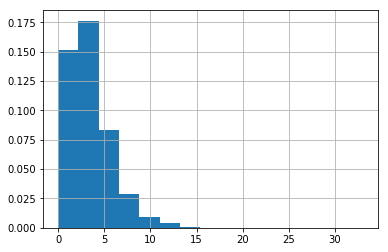

In [125]:
describe_missing(col)

Similarly, we fill missing values in `mo_sin_old_il_acct` with the rounded mean, as all the values are integers.



In [126]:
X_test[col].fillna(np.round(X_train[col].mean()), inplace=True)
X_train[col].fillna(np.round(X_train[col].mean()), inplace=True)

In [127]:
# find column with most missing values
col = X_train.count().idxmin()
col

'num_actv_rev_tl'

0.08589313152782384
count    540175.000000
mean          5.657481
std           3.207305
min           0.000000
25%           3.000000
50%           5.000000
75%           7.000000
max          57.000000
Name: num_actv_rev_tl, dtype: float64
0    0.846149
1    0.153851
Name: loan_status, dtype: float64


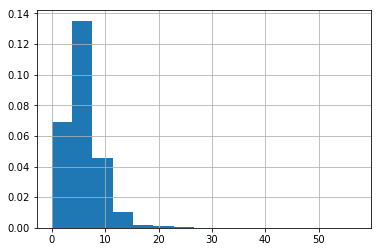

In [128]:
describe_missing(col)

Similarly, we fill missing values in `mo_sin_old_il_acct` with the rounded mean, as all the values are integers.



In [129]:
X_test[col].fillna(np.round(X_train[col].mean()), inplace=True)
X_train[col].fillna(np.round(X_train[col].mean()), inplace=True)

In [130]:
# find column with most missing values
col = X_train.count().idxmin()
col

'num_bc_tl'

0.08589313152782384
count    540175.000000
mean          8.440230
std           4.874069
min           0.000000
25%           5.000000
50%           8.000000
75%          11.000000
max          68.000000
Name: num_bc_tl, dtype: float64
0    0.846149
1    0.153851
Name: loan_status, dtype: float64


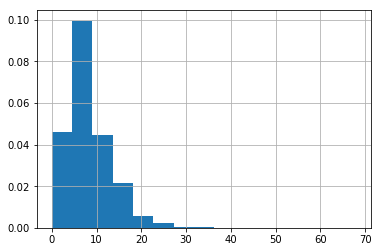

In [131]:
describe_missing(col)

Similarly, we fill missing values in `mo_sin_old_il_acct` with the rounded mean, as all the values are integers.



In [132]:
X_test[col].fillna(np.round(X_train[col].mean()), inplace=True)
X_train[col].fillna(np.round(X_train[col].mean()), inplace=True)

In [133]:
# find column with most missing values
col = X_train.count().idxmin()
col

'num_il_tl'

0.08589313152782384
count    540175.000000
mean          8.606615
std           7.348806
min           0.000000
25%           4.000000
50%           7.000000
75%          11.000000
max         150.000000
Name: num_il_tl, dtype: float64
0    0.846149
1    0.153851
Name: loan_status, dtype: float64


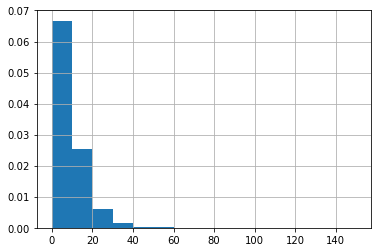

In [134]:
describe_missing(col)

Similarly, we fill missing values in `mo_sin_old_il_acct` with the rounded mean, as all the values are integers.



In [135]:
X_test[col].fillna(np.round(X_train[col].mean()), inplace=True)
X_train[col].fillna(np.round(X_train[col].mean()), inplace=True)

In [136]:
# find column with most missing values
col = X_train.count().idxmin()
col

'num_op_rev_tl'

0.08589313152782384
count    540175.000000
mean          8.293651
std           4.432372
min           0.000000
25%           5.000000
50%           7.000000
75%          10.000000
max          79.000000
Name: num_op_rev_tl, dtype: float64
0    0.846149
1    0.153851
Name: loan_status, dtype: float64


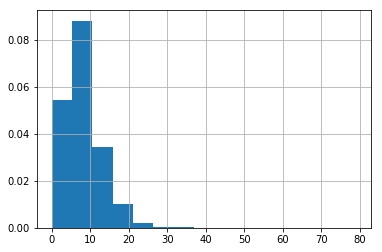

In [137]:
describe_missing(col)

Similarly, we fill missing values in `mo_sin_old_il_acct` with the rounded mean, as all the values are integers.



In [138]:
X_test[col].fillna(np.round(X_train[col].mean()), inplace=True)
X_train[col].fillna(np.round(X_train[col].mean()), inplace=True)

In [139]:
# find column with most missing values
col = X_train.count().idxmin()
col

'num_rev_tl_bal_gt_0'

0.08589313152782384
count    540175.000000
mean          5.615147
std           3.140897
min           0.000000
25%           3.000000
50%           5.000000
75%           7.000000
max          45.000000
Name: num_rev_tl_bal_gt_0, dtype: float64
0    0.846149
1    0.153851
Name: loan_status, dtype: float64


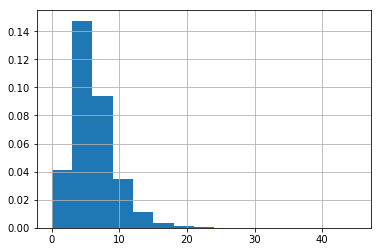

In [140]:
describe_missing(col)

Similarly, we fill missing values in `mo_sin_old_il_acct` with the rounded mean, as all the values are integers.



In [141]:
X_test[col].fillna(np.round(X_train[col].mean()), inplace=True)
X_train[col].fillna(np.round(X_train[col].mean()), inplace=True)

In [142]:
# find column with most missing values
col = X_train.count().idxmin()
col

'num_tl_op_past_12m'

0.08589313152782384
count    540175.000000
mean          2.200352
std           1.818457
min           0.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          28.000000
Name: num_tl_op_past_12m, dtype: float64
0    0.846149
1    0.153851
Name: loan_status, dtype: float64


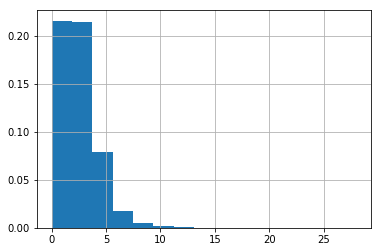

In [143]:
describe_missing(col)

Similarly, we fill missing values in `mo_sin_old_il_acct` with the rounded mean, as all the values are integers.



In [144]:
X_test[col].fillna(np.round(X_train[col].mean()), inplace=True)
X_train[col].fillna(np.round(X_train[col].mean()), inplace=True)

In [145]:
# find column with most missing values
col = X_train.count().idxmin()
col

'tot_coll_amt'

0.08589313152782384
count    5.401750e+05
mean     2.347863e+02
std      1.260101e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      9.152545e+06
Name: tot_coll_amt, dtype: float64
0    0.846149
1    0.153851
Name: loan_status, dtype: float64


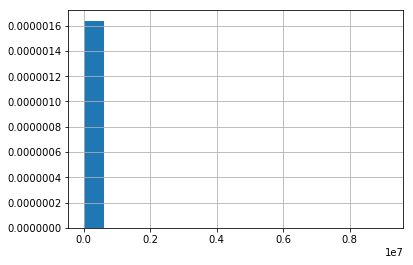

In [146]:
describe_missing(col)

Similarly, we fill missing values in `mo_sin_old_il_acct` with the rounded mean, as all the values are integers.



In [147]:
X_test[col].fillna(np.round(X_train[col].mean()), inplace=True)
X_train[col].fillna(np.round(X_train[col].mean()), inplace=True)

In [148]:
# find column with most missing values
col = X_train.count().idxmin()
col

'tot_cur_bal'

0.08589313152782384
count    5.401750e+05
mean     1.406487e+05
std      1.551070e+05
min      0.000000e+00
25%      2.962700e+04
50%      8.175100e+04
75%      2.102030e+05
max      8.000078e+06
Name: tot_cur_bal, dtype: float64
0    0.846149
1    0.153851
Name: loan_status, dtype: float64


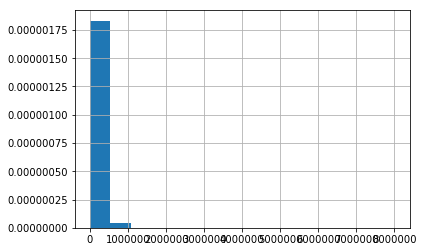

In [149]:
describe_missing(col)

Similarly, we fill missing values in `mo_sin_old_il_acct` with the rounded mean, as all the values are integers.



In [150]:
X_test[col].fillna(np.round(X_train[col].mean()), inplace=True)
X_train[col].fillna(np.round(X_train[col].mean()), inplace=True)

In [151]:
# find column with most missing values
col = X_train.count().idxmin()
col

'tot_hi_cred_lim'

0.08589313152782384
count    5.401750e+05
mean     1.722601e+05
std      1.741855e+05
min      0.000000e+00
25%      4.887650e+04
50%      1.123450e+05
75%      2.496860e+05
max      9.999999e+06
Name: tot_hi_cred_lim, dtype: float64
0    0.846149
1    0.153851
Name: loan_status, dtype: float64


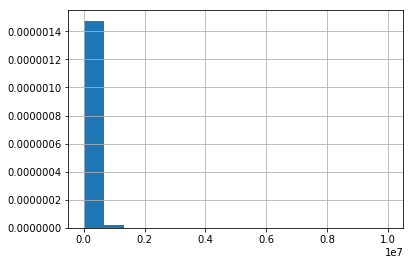

In [152]:
describe_missing(col)

Similarly, we fill missing values in `mo_sin_old_il_acct` with the rounded mean, as all the values are integers.



In [153]:
X_test[col].fillna(np.round(X_train[col].mean()), inplace=True)
X_train[col].fillna(np.round(X_train[col].mean()), inplace=True)

In [154]:
# find column with most missing values
col = X_train.count().idxmin()
col

'total_il_high_credit_limit'

0.08589313152782384
count    5.401750e+05
mean     4.076918e+04
std      4.190599e+04
min      0.000000e+00
25%      1.418100e+04
50%      3.077400e+04
75%      5.495250e+04
max      2.101913e+06
Name: total_il_high_credit_limit, dtype: float64
0    0.846149
1    0.153851
Name: loan_status, dtype: float64


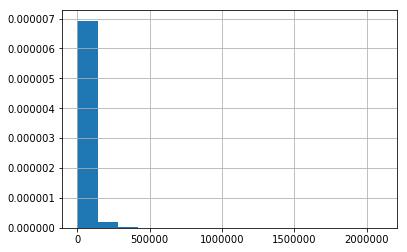

In [155]:
describe_missing(col)

Similarly, we fill missing values in `mo_sin_old_il_acct` with the rounded mean, as all the values are integers.



In [156]:
X_test[col].fillna(np.round(X_train[col].mean()), inplace=True)
X_train[col].fillna(np.round(X_train[col].mean()), inplace=True)

In [157]:
# find column with most missing values
col = X_train.count().idxmin()
col

'total_rev_hi_lim'

0.08589313152782384
count    5.401750e+05
mean     3.169878e+04
std      3.742151e+04
min      0.000000e+00
25%      1.380000e+04
50%      2.340000e+04
75%      3.930000e+04
max      9.999999e+06
Name: total_rev_hi_lim, dtype: float64
0    0.846149
1    0.153851
Name: loan_status, dtype: float64


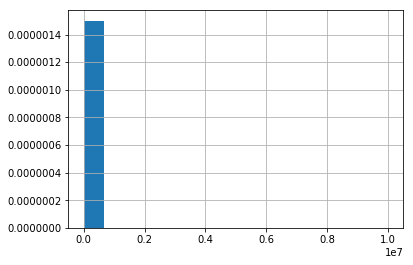

In [158]:
describe_missing(col)

Similarly, we fill missing values in `mo_sin_old_il_acct` with the rounded mean, as all the values are integers.



In [159]:
X_test[col].fillna(np.round(X_train[col].mean()), inplace=True)
X_train[col].fillna(np.round(X_train[col].mean()), inplace=True)

In [160]:
# find column with most missing values
col = X_train.count().idxmin()
col

'num_bc_sats'

0.0709590951243121
count    549000.000000
mean          4.708342
std           2.853430
min           0.000000
25%           3.000000
50%           4.000000
75%           6.000000
max          57.000000
Name: num_bc_sats, dtype: float64
0    0.851283
1    0.148717
Name: loan_status, dtype: float64


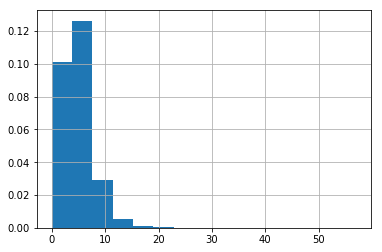

In [161]:
describe_missing(col)

Similarly, we fill missing values in `mo_sin_old_il_acct` with the rounded mean, as all the values are integers.



In [162]:
X_test[col].fillna(np.round(X_train[col].mean()), inplace=True)
X_train[col].fillna(np.round(X_train[col].mean()), inplace=True)

In [163]:
# find column with most missing values
col = X_train.count().idxmin()
col

'num_sats'

0.0709590951243121
count    549000.000000
mean         11.616492
std           5.331169
min           0.000000
25%           8.000000
50%          11.000000
75%          14.000000
max          84.000000
Name: num_sats, dtype: float64
0    0.851283
1    0.148717
Name: loan_status, dtype: float64


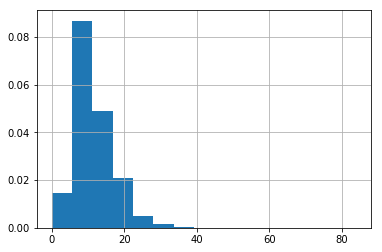

In [164]:
describe_missing(col)

Similarly, we fill missing values in `mo_sin_old_il_acct` with the rounded mean, as all the values are integers.



In [165]:
X_test[col].fillna(np.round(X_train[col].mean()), inplace=True)
X_train[col].fillna(np.round(X_train[col].mean()), inplace=True)

In [166]:
# find column with most missing values
col = X_train.count().idxmin()
col

'bc_util'

0.07037188712068394
count    549347.000000
mean         61.663812
std          27.874533
min           0.000000
25%          40.900000
50%          65.600000
75%          86.000000
max         243.800000
Name: bc_util, dtype: float64
0    0.842684
1    0.157316
Name: loan_status, dtype: float64


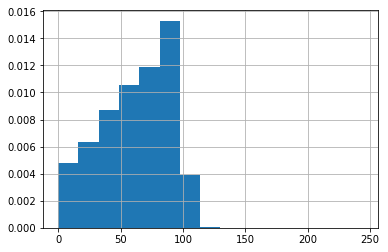

In [167]:
describe_missing(col)

Similarly, we fill missing values in `mo_sin_old_il_acct` with the rounded mean, as all the values are integers.



In [168]:
X_test[col].fillna(np.round(X_train[col].mean()), inplace=True)
X_train[col].fillna(np.round(X_train[col].mean()), inplace=True)

In [169]:
# find column with most missing values
col = X_train.count().idxmin()
col

'percent_bc_gt_75'

0.07012651201830329
count    549492.000000
mean         47.383320
std          35.633044
min           0.000000
25%          16.700000
50%          50.000000
75%          75.000000
max         100.000000
Name: percent_bc_gt_75, dtype: float64
0    0.842785
1    0.157215
Name: loan_status, dtype: float64


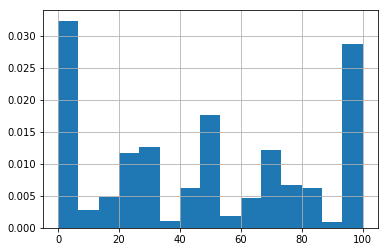

In [170]:
describe_missing(col)

Similarly, we fill missing values in `mo_sin_old_il_acct` with the rounded mean, as all the values are integers.



In [171]:
X_test[col].fillna(np.round(X_train[col].mean()), inplace=True)
X_train[col].fillna(np.round(X_train[col].mean()), inplace=True)

In [172]:
# find column with most missing values
col = X_train.count().idxmin()
col

'bc_open_to_buy'

0.06977283342245809
count    549701.000000
mean       9417.810744
std       14514.524800
min           0.000000
25%        1301.000000
50%        4235.000000
75%       11290.000000
max      497445.000000
Name: bc_open_to_buy, dtype: float64
0    0.843128
1    0.156872
Name: loan_status, dtype: float64


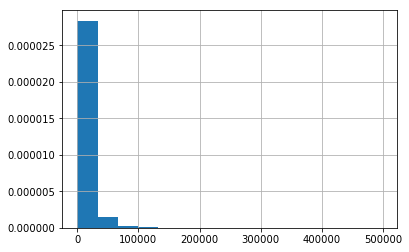

In [173]:
describe_missing(col)

Similarly, we fill missing values in `mo_sin_old_il_acct` with the rounded mean, as all the values are integers.



In [174]:
X_test[col].fillna(np.round(X_train[col].mean()), inplace=True)
X_train[col].fillna(np.round(X_train[col].mean()), inplace=True)

In [175]:
# find column with most missing values
col = X_train.count().idxmin()
col

'mths_since_recent_bc'

0.06900963224195
count    550152.000000
mean         23.401909
std          29.611121
min           0.000000
25%           6.000000
50%          13.000000
75%          28.000000
max         616.000000
Name: mths_since_recent_bc, dtype: float64
0    0.843771
1    0.156229
Name: loan_status, dtype: float64


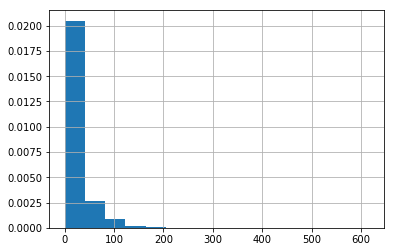

In [176]:
describe_missing(col)

Similarly, we fill missing values in `mo_sin_old_il_acct` with the rounded mean, as all the values are integers.



In [177]:
X_test[col].fillna(np.round(X_train[col].mean()), inplace=True)
X_train[col].fillna(np.round(X_train[col].mean()), inplace=True)

In [178]:
# find column with most missing values
col = X_train.count().idxmin()
col

'acc_open_past_24mths'

0.060098285420319086
count    555418.000000
mean          4.710260
std           3.141612
min           0.000000
25%           2.000000
50%           4.000000
75%           6.000000
max          56.000000
Name: acc_open_past_24mths, dtype: float64
0    0.853973
1    0.146027
Name: loan_status, dtype: float64


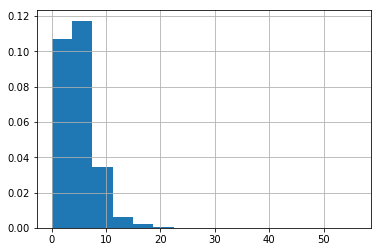

In [179]:
describe_missing(col)

Similarly, we fill missing values in `mo_sin_old_il_acct` with the rounded mean, as all the values are integers.



In [180]:
X_test[col].fillna(np.round(X_train[col].mean()), inplace=True)
X_train[col].fillna(np.round(X_train[col].mean()), inplace=True)

In [181]:
# find column with most missing values
col = X_train.count().idxmin()
col

'mort_acc'

0.060098285420319086
count    555418.000000
mean          1.763861
std           2.087122
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          47.000000
Name: mort_acc, dtype: float64
0    0.853973
1    0.146027
Name: loan_status, dtype: float64


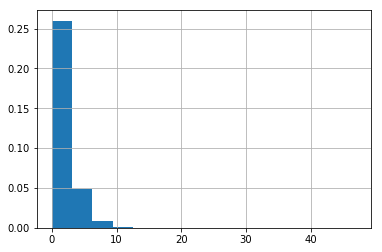

In [182]:
describe_missing(col)

Similarly, we fill missing values in `mo_sin_old_il_acct` with the rounded mean, as all the values are integers.



In [183]:
X_test[col].fillna(np.round(X_train[col].mean()), inplace=True)
X_train[col].fillna(np.round(X_train[col].mean()), inplace=True)

In [184]:
# find column with most missing values
col = X_train.count().idxmin()
col

'total_bal_ex_mort'

0.060098285420319086
count    5.554180e+05
mean     4.849592e+04
std      4.601877e+04
min      0.000000e+00
25%      2.073925e+04
50%      3.672200e+04
75%      6.112600e+04
max      2.688920e+06
Name: total_bal_ex_mort, dtype: float64
0    0.853973
1    0.146027
Name: loan_status, dtype: float64


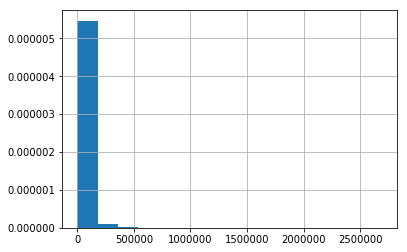

In [185]:
describe_missing(col)

Similarly, we fill missing values in `mo_sin_old_il_acct` with the rounded mean, as all the values are integers.



In [186]:
X_test[col].fillna(np.round(X_train[col].mean()), inplace=True)
X_train[col].fillna(np.round(X_train[col].mean()), inplace=True)

In [187]:
# find column with most missing values
col = X_train.count().idxmin()
col

'total_bc_limit'

0.060098285420319086
count    5.554180e+05
mean     2.077245e+04
std      2.068903e+04
min      0.000000e+00
25%      7.500000e+03
50%      1.450000e+04
75%      2.700000e+04
max      1.105500e+06
Name: total_bc_limit, dtype: float64
0    0.853973
1    0.146027
Name: loan_status, dtype: float64


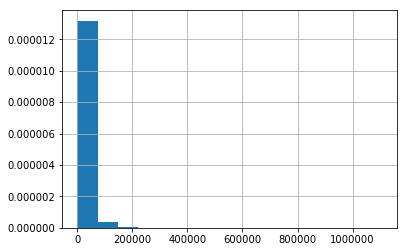

In [188]:
describe_missing(col)

Similarly, we fill missing values in `mo_sin_old_il_acct` with the rounded mean, as all the values are integers.



In [189]:
X_test[col].fillna(np.round(X_train[col].mean()), inplace=True)
X_train[col].fillna(np.round(X_train[col].mean()), inplace=True)

In [190]:
# find column with most missing values
col = X_train.count().idxmin()
col

'pub_rec_bankruptcies'

0.0009171952102780015
count    590390.000000
mean          0.131142
std           0.373357
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          12.000000
Name: pub_rec_bankruptcies, dtype: float64
0    0.824723
1    0.175277
Name: loan_status, dtype: float64


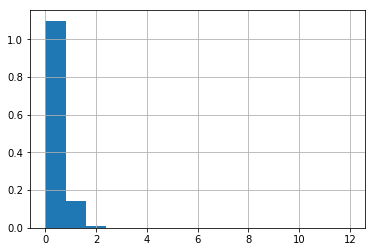

In [191]:
describe_missing(col)

Similarly, we fill missing values in `mo_sin_old_il_acct` with the rounded mean, as all the values are integers.



In [192]:
X_test[col].fillna(np.round(X_train[col].mean()), inplace=True)
X_train[col].fillna(np.round(X_train[col].mean()), inplace=True)

In [193]:
# find column with most missing values
col = X_train.count().idxmin()
col

'revol_util'

0.000609207150738156
count    590572.000000
mean          0.531168
std           0.243414
min           0.000000
25%           0.351000
50%           0.538000
75%           0.720000
max           8.923000
Name: revol_util, dtype: float64
0    0.769444
1    0.230556
Name: loan_status, dtype: float64


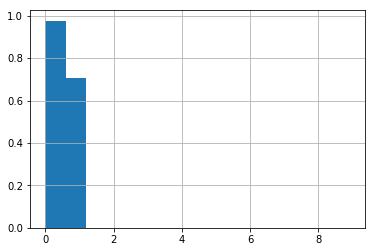

In [194]:
describe_missing(col)

Similarly, we fill missing values in `mo_sin_old_il_acct` with the rounded mean, as all the values are integers.



In [195]:
X_test[col].fillna(np.round(X_train[col].mean()), inplace=True)
X_train[col].fillna(np.round(X_train[col].mean()), inplace=True)

In [196]:
# find column with most missing values
col = X_train.count().idxmin()
col

'dti'

3.8921567963826634e-05
count    590909.000000
mean         17.837213
std           8.793287
min           0.000000
25%          11.620000
50%          17.330000
75%          23.590000
max         999.000000
Name: dti, dtype: float64
0    0.826087
1    0.173913
Name: loan_status, dtype: float64


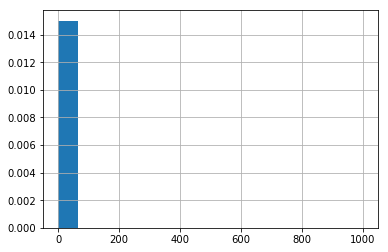

In [197]:
describe_missing(col)

Similarly, we fill missing values in `mo_sin_old_il_acct` with the rounded mean, as all the values are integers.



In [198]:
X_test[col].fillna(np.round(X_train[col].mean()), inplace=True)
X_train[col].fillna(np.round(X_train[col].mean()), inplace=True)

In [199]:
# find column with most missing values
col = X_train.count().idxmin()
col

'inq_last_6mths'

1.6922420853837667e-06
count    590931.000000
mean          0.726262
std           0.993930
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           8.000000
Name: inq_last_6mths, dtype: float64
0    1.0
Name: loan_status, dtype: float64


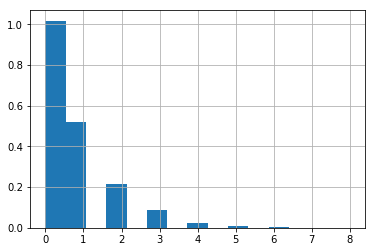

In [200]:
describe_missing(col)

Similarly, we fill missing values in `mo_sin_old_il_acct` with the rounded mean, as all the values are integers.



In [201]:
X_test[col].fillna(np.round(X_train[col].mean()), inplace=True)
X_train[col].fillna(np.round(X_train[col].mean()), inplace=True)

Check for any last missing values.


In [205]:
X_train.isnull().any().sum(), X_test.isnull().any().sum()

(0, 0)

Save the train and test splits to csv files.



In [206]:
X_train.to_csv("data/X_train.csv", index=False)
X_test.to_csv("data/X_test.csv", index=False)
y_train.to_csv("data/y_train.csv", index=False)
y_test.to_csv("data/y_test.csv", index=False)